In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import random

import scipy.stats as stats

In [307]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score

In [308]:
plt.style.use('ggplot')

In [309]:
df = pd.read_csv('../data/kandidater_data.csv').dropna()

# gender dummy question
df['IsMale'] = df["Gender"].map(lambda x: True if x == "M" else False)
df['26'] = df["Gender"].map(lambda x: -2 if x == "M" else 2) # random.choices([2, -2], weights=[0.5, 0.5])[0]

# age dummy question
df['Age'] = 2022 - df.Birthdate.str[:4].astype(int)
df['IsYoung'] = df['Age'].map(lambda x: True if x <= 30 else False)
df['27'] = df.IsYoung.map(lambda x: -2 if x else 2)

# block dummy question
blok_dict = {
    'A': 1,
    'Ø': 1,
    'F': 1,
    'Å': 1,
    'Q': 1,
    'V': 0,
    'C': 0,
    'O': 0,
    'I': 0,
    'Æ': 0,
    'D': 0,
    # ikke så rød-blå
    'B': 1,
    'M': 0,
    'K': 0
}

df['Block'] = df.CurrentPartyCode.map(blok_dict)
df['IsRed'] = df.Block.astype(bool)
df['28'] = df.Block.apply(lambda x: -2 if x==1 else 2)

# education dummy variable
edu_map = {
    'Grundskole': 1,
    '10. klasse': 2,
    'Erhvervsuddannelse': 4,
    'Gymnasial uddannelse': 4,
    'Seminaruddannelse': 6,
    'Bachelor-/diplomuddannelse': 6,
    'Kandidat-/masteruddannelse': 7,
    'Ph.d-uddannelse': 8,
    'Ph.d.-uddannelse': 8
}
df['EducationLevel'] = df.Education.map(edu_map)
df['IsHighEducation'] = df.EducationLevel.map(lambda x: False if x < 6 else True)
df['29'] = df.IsHighEducation.apply(lambda x: -2 if x else 2)

# Profession
political_professions = {
    'Folketingsmedlem' : True,
     'Minister' : True,
     'Ikke oplyst' : False,
     'Offentligt ansat' : False,
     'Byråds- eller regionsrådsmedlem' : True,
     'Privat ansat/selvstændig' : False,
     'Studerende' : False,
     'Leder' : False,
     'Ordfører for et parti' : True,
     'Udenfor arbejdsmarkedet' : False,
     'Partileder' : True,
     'Europa-Parlamentariker' : True,
}

df["IsPolitical"] = df["Profession"].map(political_professions)
df['30'] = df.IsPolitical.apply(lambda x: -2 if x else 2)

df.dropna(inplace=True)

In [310]:
TREATMENT = 'IsMale'
OUTCOME = [str(i) for i in range(1, 31)]
always_drop = ['ID', 'Firstname', 'LastName', 'Birthdate', 'Block', 'EducationLevel', 'Gender']
DROP = ['IsYoung', 'IsRed', 'IsPolitical', 'IsHighEducation']  #  + [str(i) for i in range(2, 31)]
df.drop(columns=always_drop + DROP, inplace=True)
df.groupby(TREATMENT)[OUTCOME].describe()

1                                           2        ...    29  \
        count mean  std   min   25%  50%  75%  max  count  mean  ...   75%   
IsMale                                                           ...         
False  286.00 0.64 1.40 -2.00 -1.00 1.00 2.00 2.00 286.00 -0.08  ... -2.00   
True   467.00 0.19 1.42 -2.00 -1.00 1.00 2.00 2.00 467.00 -0.48  ...  2.00   

                30                                       
        max  count mean  std   min   25%  50%  75%  max  
IsMale                                                   
False  2.00 286.00 0.95 1.76 -2.00 -2.00 2.00 2.00 2.00  
True   2.00 467.00 1.13 1.65 -2.00  2.00 2.00 2.00 2.00  

[2 rows x 240 columns]

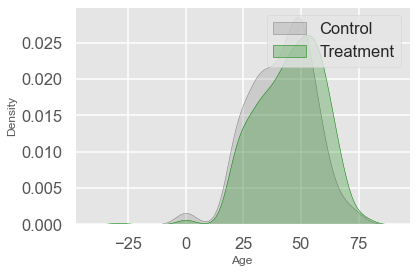

In [311]:
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treatment'
sns.kdeplot(data=df[~df[TREATMENT]], x='Age', shade=True, 
            color=C_COLOUR, label=C_LABEL)
sns.kdeplot(data=df[df[TREATMENT]], x='Age', shade=True, 
            color=T_COLOUR, label=T_LABEL)
plt.legend();

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(0.0, 1.0)

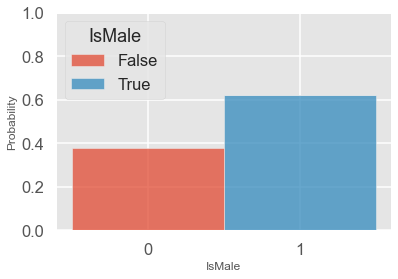

In [312]:
ax = sns.histplot(df, x=TREATMENT, hue='IsMale', multiple='stack', discrete=True, stat='probability')
ax.set_xticks([0,1])
ax.set_ylim(0,1)

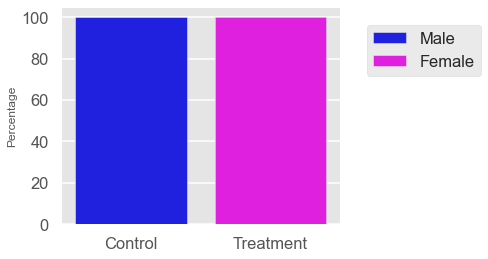

In [313]:
F_COLOUR = 'magenta'
M_COLOUR = 'blue'
F_LABEL = 'Female'
M_LABEL = 'Male'

gender = 100 * pd.crosstab(df[TREATMENT].replace({True: T_LABEL, 
                                                  False: C_LABEL}), 
                           df['IsMale'].replace({True: 'Female',
                                                    False: 'Male'}), 
                           normalize='index')
gender['All'] = 100
plt.figure(figsize=(5, 4))
sns.barplot(data=gender, x=gender.index.astype(str),  y="All", 
            color=M_COLOUR, label=M_LABEL)
sns.barplot(data=gender, x=gender.index.astype(str),  y='Female', 
            color=F_COLOUR, label=F_LABEL)
plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage');

<AxesSubplot:xlabel='Count', ylabel='CurrentPartyCode'>

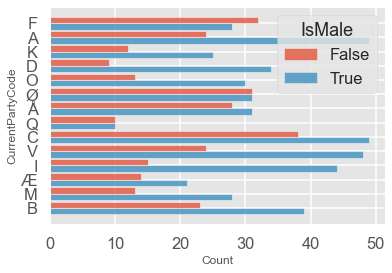

In [314]:
fig, ax = plt.subplots()
sns.histplot(df, y='CurrentPartyCode', hue=TREATMENT, multiple="dodge", shrink=.9)

<AxesSubplot:xlabel='Count', ylabel='Profession'>

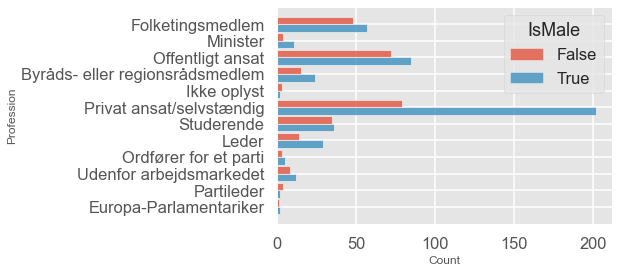

In [315]:
fig, ax = plt.subplots()
sns.histplot(df, y='Profession', hue=TREATMENT, multiple="dodge", shrink=.9)

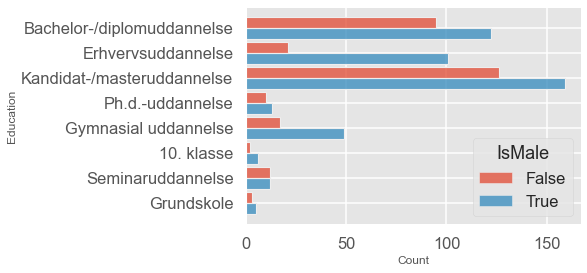

In [316]:
try:
    fig, ax = plt.subplots()
    sns.histplot(df, y='Education', hue=TREATMENT, multiple="dodge", shrink=.9)
except ValueError:
    print('this one being plotted')

In [317]:
# Build a descriptive model
t = df[TREATMENT]
X = pd.get_dummies(df.drop(columns=OUTCOME + [TREATMENT]))
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', LogisticRegression())
])
pipe.fit(X, t)
# Predict
threshold = 0.5
df['proba'] = pipe.predict_proba(X)[:,1]
df['logit'] = df['proba'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['proba']>=threshold, 1, 0)
df.head()

,CurrentPartyCode,Profession,Education,1,2,3,4,5,6,7,...,IsMale,26,Age,27,28,29,30,proba,logit,pred
0,F,Folketingsmedlem,Bachelor-/diplomuddannelse,2.00,2.00,-2.00,-2.00,1.00,-2.00,1.00,...,False,2,28,-2,-2,-2,-2,0.30,-0.84,0
1,A,Minister,Erhvervsuddannelse,1.00,1.00,2.00,-2.00,2.00,-1.00,1.00,...,True,-2,41,2,-2,2,-2,0.89,2.07,1
3,K,Offentligt ansat,Bachelor-/diplomuddannelse,1.00,1.00,-2.00,-1.00,-1.00,-1.00,-1.00,...,False,2,48,2,2,-2,2,0.58,0.33,1
5,F,Byråds- eller regionsrådsmedlem,Kandidat-/masteruddannelse,1.00,1.00,-1.00,-2.00,1.00,-2.00,1.00,...,True,-2,37,2,-2,-2,-2,0.42,-0.31,0
6,D,Folketingsmedlem,Ph.d.-uddannelse,-1.00,-2.00,-1.00,2.00,2.00,2.00,-2.00,...,True,-2,55,2,2,-2,-2,0.58,0.31,1


In [318]:
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['proba']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred']).rename(columns={0: False, 
                                                       1:True})

Accuracy: 0.6680, ROC AUC: 0.6971, F1-score: 0.7610


pred,False,True
IsMale,,
False,105,181
True,69,398


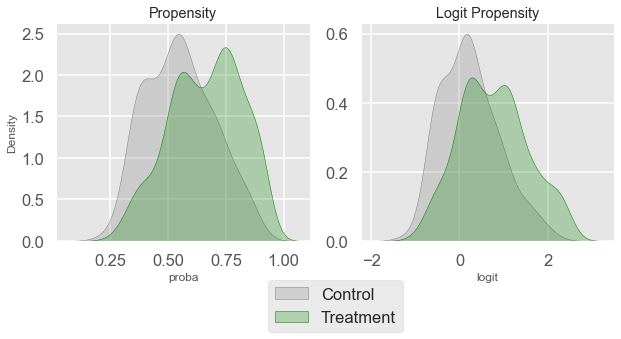

In [319]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
# Visualise propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='proba', shade=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[0])
sns.kdeplot(data=df[df[TREATMENT]], x='proba', shade=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
# Visualise logit propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='logit', shade=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[1])
sns.kdeplot(data=df[df[TREATMENT]], x='logit', shade=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");

In [323]:
# Sort by 'logit' so it's quicker to find match
df.sort_values('logit', inplace=True)
n = len(df)-1
for i, (ind, row) in enumerate(df.iterrows()): 
    # Match the most similar untreated record to each treated record
    if row[TREATMENT]:
        # Find the closest untreated match among records sorted 
        # higher. 'equal_or_above would' be more accurate but 
        # used 'above' for brevity        
        if i<n and df.iloc[i:][~df.iloc[i:][TREATMENT]].shape[0]:
            above = df.iloc[i:]
            control_above = above[~above[TREATMENT]]
            match_above = control_above.iloc[0]
            distance_above = match_above['logit'] - row['logit']
            df.loc[ind, 'match'] = match_above.name
            df.loc[ind, 'distance'] = distance_above
        
        # Find the closest untreated match among records sorted 
        # lower. 'equal_or_below' would be more accurate but 
        # used 'below' for brevity  
        if i>0 and df.iloc[:i-1][~df.iloc[:i-1][TREATMENT]].shape[0]:
            below = df.iloc[:i-1]
            control_below = below[~below[TREATMENT]]
            match_below = control_below.iloc[-1]
            distance_below = match_below['logit'] - row['logit']
            if i==n:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
            
            # Only overwrite if match_below is closer than match_above
            elif distance_below<distance_above:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
df[df[TREATMENT]]

,CurrentPartyCode,Profession,Education,1,2,3,4,5,6,7,...,Age,27,28,29,30,proba,logit,pred,match,distance
674,M,Offentligt ansat,Ph.d.-uddannelse,1.00,1.00,2.00,-2.00,1.00,1.00,-2.00,...,-29,-2,2,-2,2,0.25,-1.11,0,281.00,0.07
254,Ø,Offentligt ansat,Seminaruddannelse,2.00,2.00,-2.00,-1.00,-2.00,-2.00,1.00,...,31,2,-2,-2,2,0.30,-0.83,0,810.00,-0.00
313,O,Partileder,Kandidat-/masteruddannelse,1.00,-1.00,2.00,1.00,1.00,-1.00,-2.00,...,42,2,2,-2,-2,0.31,-0.82,0,0.00,-0.02
899,F,Folketingsmedlem,Bachelor-/diplomuddannelse,2.00,2.00,-2.00,-2.00,1.00,-2.00,1.00,...,30,-2,-2,-2,-2,0.31,-0.80,0,0.00,-0.03
268,Ø,Udenfor arbejdsmarkedet,Bachelor-/diplomuddannelse,2.00,2.00,-1.00,-1.00,1.00,-1.00,1.00,...,24,-2,-2,-2,2,0.31,-0.79,0,0.00,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,D,Privat ansat/selvstændig,Erhvervsuddannelse,-1.00,-2.00,-2.00,2.00,2.00,2.00,-2.00,...,57,2,2,2,2,0.92,2.44,1,858.00,-0.22
197,I,Privat ansat/selvstændig,Erhvervsuddannelse,-2.00,-2.00,-2.00,-2.00,2.00,2.00,-2.00,...,46,2,2,2,2,0.92,2.45,1,858.00,-0.22
870,A,Privat ansat/selvstændig,Erhvervsuddannelse,-1.00,1.00,-1.00,1.00,1.00,-2.00,-1.00,...,61,2,-2,2,2,0.92,2.47,1,858.00,-0.24
939,I,Leder,Erhvervsuddannelse,-2.00,-2.00,2.00,-1.00,2.00,2.00,-2.00,...,59,2,2,2,2,0.92,2.49,1,858.00,-0.26


In [324]:
indices = df[df['match'].notna()].index.\
          append(pd.Index(df.loc[df['match'].notna(), 'match']))
matched_df = df.loc[indices].reset_index(drop=True)
matched_df

,CurrentPartyCode,Profession,Education,1,2,3,4,5,6,7,...,Age,27,28,29,30,proba,logit,pred,match,distance
0,M,Offentligt ansat,Ph.d.-uddannelse,1.00,1.00,2.00,-2.00,1.00,1.00,-2.00,...,-29,-2,2,-2,2,0.25,-1.11,0,281.00,0.07
1,Ø,Offentligt ansat,Seminaruddannelse,2.00,2.00,-2.00,-1.00,-2.00,-2.00,1.00,...,31,2,-2,-2,2,0.30,-0.83,0,810.00,-0.00
2,O,Partileder,Kandidat-/masteruddannelse,1.00,-1.00,2.00,1.00,1.00,-1.00,-2.00,...,42,2,2,-2,-2,0.31,-0.82,0,0.00,-0.02
3,F,Folketingsmedlem,Bachelor-/diplomuddannelse,2.00,2.00,-2.00,-2.00,1.00,-2.00,1.00,...,30,-2,-2,-2,-2,0.31,-0.80,0,0.00,-0.03
4,Ø,Udenfor arbejdsmarkedet,Bachelor-/diplomuddannelse,2.00,2.00,-1.00,-1.00,1.00,-1.00,1.00,...,24,-2,-2,-2,2,0.31,-0.79,0,0.00,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,K,Privat ansat/selvstændig,Erhvervsuddannelse,-1.00,-2.00,2.00,-2.00,2.00,1.00,-2.00,...,59,2,2,2,2,0.90,2.22,1,NaN,NaN
930,K,Privat ansat/selvstændig,Erhvervsuddannelse,-1.00,-2.00,2.00,-2.00,2.00,1.00,-2.00,...,59,2,2,2,2,0.90,2.22,1,NaN,NaN
931,K,Privat ansat/selvstændig,Erhvervsuddannelse,-1.00,-2.00,2.00,-2.00,2.00,1.00,-2.00,...,59,2,2,2,2,0.90,2.22,1,NaN,NaN
932,K,Privat ansat/selvstændig,Erhvervsuddannelse,-1.00,-2.00,2.00,-2.00,2.00,1.00,-2.00,...,59,2,2,2,2,0.90,2.22,1,NaN,NaN


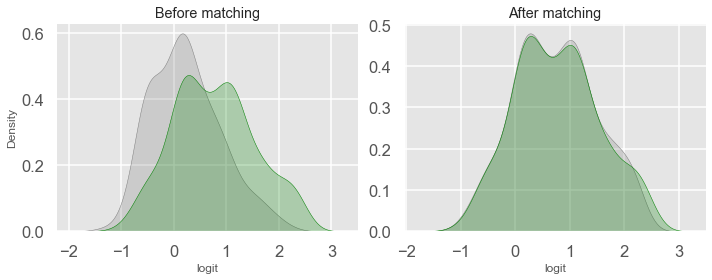

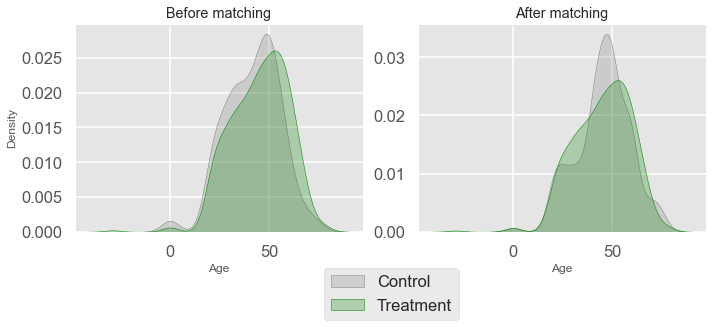

In [325]:
for var in ['logit', 'Age']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=df[~df[TREATMENT]], x=var, shade=True, 
                color=C_COLOUR, label=C_LABEL, ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]], x=var, shade=True, 
                color=T_COLOUR, label=T_LABEL, ax=ax[0])
    ax[0].set_title('Before matching')
    
    # Visualise new distribution
    sns.kdeplot(data=matched_df[~matched_df[TREATMENT]], x=var, 
                shade=True, color=C_COLOUR, label=C_LABEL, ax=ax[1])
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]], x=var, 
                shade=True, color=T_COLOUR, label=T_LABEL, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

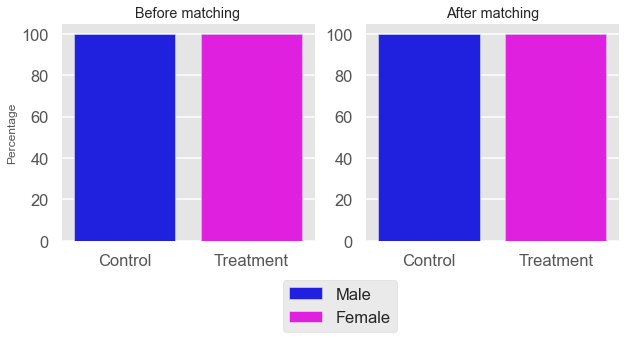

In [326]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Visualise original distribution
sns.barplot(data=gender, x=gender.index.astype(str), y="All", 
            color=M_COLOUR, label=M_LABEL, ax=ax[0])
sns.barplot(data=gender, x=gender.index.astype(str), y='Female', 
            color=F_COLOUR, label=F_LABEL, ax=ax[0])
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Before matching')
# Visualise new distribution
gender_after = 100 * pd.crosstab(
    matched_df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}), 
    matched_df['IsMale'].replace({True: 'Female', False: 'Male'}), 
    normalize='index'
)
gender_after['All'] = 100
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y="All", color=M_COLOUR, label=M_LABEL, ax=ax[1])
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y='Female', color=F_COLOUR, label=F_LABEL, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_title('After matching')
ax[1].set_ylabel('');

In [327]:
GROUP_T = df[df[TREATMENT]]
GROUP_C = df[~df[TREATMENT]].loc[GROUP_T.match]

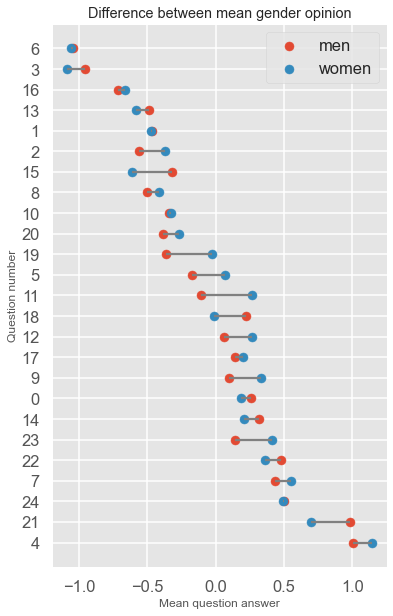

In [330]:
fig, ax = plt.subplots(figsize=(6,10))
y = np.arange(25)
x1 = np.array([GROUP_C[str(i)].mean() for i in range(1, 26)])
x2 = np.array([GROUP_T[str(i)].mean() for i in range(1, 26)])

X = np.vstack((x1, x2)).T
idx = np.argsort(-np.mean(X, axis=1))
# idx = np.argsort(np.abs(x1 - x2))
x1 = x1[idx]
x2 = x2[idx]

for n in y:
    a = min(x1[n], x2[n])
    b = max(x1[n], x2[n])
    ax.hlines(n, a, b, color='grey')

ax.scatter(x1, y, label='men')
ax.scatter(x2, y, label='women')

ax.set_yticks(y)

ax.set_title('Difference between mean gender opinion')
ax.set_xlabel('Mean question answer')
ax.set_ylabel('Question number')

ax.set_yticklabels(y[idx])
ax.legend()

In [332]:
_, p_values = stats.ttest_rel(GROUP_C[OUTCOME], GROUP_T[OUTCOME])

<ipython-input-332-9c11ca8e0049>:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_values = stats.ttest_rel(GROUP_C[OUTCOME], GROUP_T[OUTCOME])


In [342]:
np.where(p_values < 0.002)

(array([11, 21, 25], dtype=int64),)